In [1]:
# import 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

'''
# Load the dataset
data = pd.read_excel('../day04/UN_demographic_indicators.xlsx', sheet_name='Estimates', skiprows=16)

# convert columns to numeric after 'Year'
numeric_columns = data.columns[11:]
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# remove unecessary columns, index
data = data.drop(columns=['Index'])

# rename some common columns
data = data.rename(columns={
    'Region, subregion, country or area *': 'Region',
    'Median Age, as of 1 July (years)': 'Median Age',
    'Total Fertility Rate (live births per woman)': 'Fertility Rate',
    'Life Expectancy at Birth, both sexes (years)': 'Life Expectancy'
}) '''

# load the 2nd dataset
raw_data = pd.read_csv('../data/global_development_all_countries.csv', dtype={36: 'float64'})

# Global Economic Performance Analysis: Composite Scoring & Rankings

**Objective**: Develop a comprehensive country performance framework using standardized economic metrics to identify emerging economic powerhouses and declining economies. This analysis employs z-score normalization to create comparable metrics across countries, enabling identification of: (1) top-performing economies using composite scoring, (2) rising vs. falling economic patterns, (3) temporal performance trends, and (4) multi-dimensional country clustering based on economic fundamentals.

In [2]:
data = raw_data.copy()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58343 entries, 0 to 58342
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   countryname  58343 non-null  object 
 1   ISO3         58343 non-null  object 
 2   year         58343 non-null  int64  
 3   rGDP_pc      22233 non-null  float64
 4   inv_GDP      15256 non-null  float64
 5   finv_GDP     14035 non-null  float64
 6   exports_GDP  16707 non-null  float64
 7   imports_GDP  16385 non-null  float64
 8   REER         11585 non-null  float64
 9   govrev_GDP   14879 non-null  float64
 10  govdef_GDP   13917 non-null  float64
 11  govdebt_GDP  14668 non-null  float64
 12  CPI          19358 non-null  float64
 13  infl         25238 non-null  float64
 14  pop          51938 non-null  float64
 15  imports_USD  19680 non-null  float64
 16  exports_USD  20061 non-null  float64
dtypes: float64(14), int64(1), object(2)
memory usage: 7.6+ MB


## Data Integration & Preprocessing

**Global Development Dataset**: Utilizing comprehensive economic indicators spanning multiple dimensions of national performance. The dataset includes GDP metrics, trade data, fiscal indicators, and demographic variables, providing a holistic view of economic development patterns across countries and time periods.

In [3]:
from scipy.stats import zscore

# Step 1: Define your metrics
metrics = [
    'rGDP_pc',
    'exports_USD',
    'inv_GDP',
    'govrev_GDP',
    'govdef_GDP',
    'govdebt_GDP',
    'infl',
    'pop'
]

# Step 2: Drop rows with missing values in required columns
df = data.dropna(subset=metrics + ['year', 'ISO3'])

# Step 3: Keep only the latest year per country
latest_years = df.groupby('ISO3')['year'].transform('max')
latest_df = df[df['year'] == latest_years]

# Step 4: Calculate z-scores for selected metrics
z_df = latest_df.copy()
z_df[metrics] = z_df[metrics].apply(zscore)

# Optional: Composite score (sum or mean of z-scores)
z_df['CompositeScore'] = z_df[metrics].mean(axis=1)

# Optional: Sort by CompositeScore descending
z_df = z_df.sort_values(by='CompositeScore', ascending=False)

# Preview top countries
print(z_df[['countryname', 'ISO3', 'year', 'CompositeScore'] + metrics].head(10))


         countryname ISO3  year  CompositeScore   rGDP_pc  exports_USD  \
9557           China  CHN  2025        2.341610 -0.244795     8.188326   
56023      Venezuela  VEN  2020        1.916186 -0.253308    -0.386928   
39876          Nauru  NRU  2020        1.396994 -0.252277    -0.386804   
24650          India  IND  2025        1.350725 -0.238876     1.450995   
25110           Iran  IRN  2023        1.240353  7.947081     1.441498   
55114  United States  USA  2025        1.134841 -0.246083     6.865682   
56557        Vietnam  VNM  2024        0.910751  6.968650     0.564479   
27462          Japan  JPN  2025        0.904800  0.278909     1.713862   
24344      Indonesia  IDN  2025        0.875660  5.303831     0.325369   
29136    South Korea  KOR  2025        0.802316  4.133217     1.484013   

        inv_GDP  govrev_GDP  govdef_GDP  govdebt_GDP       infl       pop  
9557   2.182192   -0.161134   -0.841741     0.667060  -0.105654  9.048623  
56023 -1.904436   -1.523563   -0.

## Z-Score Normalization & Composite Scoring

**Methodological Framework**: Implementing z-score standardization to create comparable metrics across diverse economic indicators. This approach transforms variables with different scales (GDP in trillions, inflation in percentages, population in millions) into standardized scores with mean=0 and standard deviation=1, enabling meaningful cross-metric comparisons and composite score creation.

In [4]:
# Top 10 composite performers
top_10 = z_df[['countryname', 'CompositeScore']].head(10)

# Bottom 10 composite performers
bottom_10 = z_df[['countryname', 'CompositeScore']].tail(10)

# Create country lists
top_countries = top_10['countryname'].tolist()
bottom_countries = bottom_10['countryname'].tolist()


## Economic Performance Rankings

**Composite Score Analysis**: Creating comprehensive country rankings based on averaged z-scores across key economic metrics. This methodology identifies both top-performing economies (positive composite scores indicating above-average performance across multiple dimensions) and underperforming countries, providing insights into global economic hierarchies and development patterns.

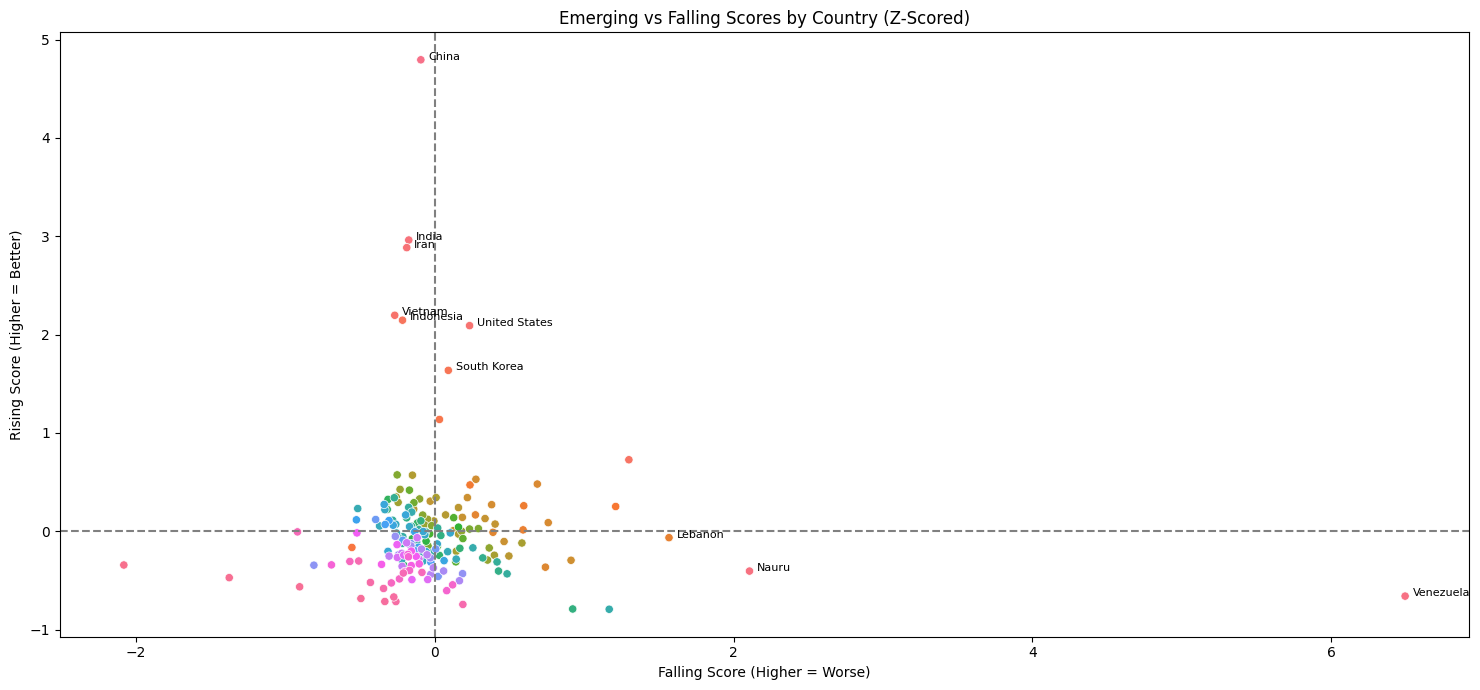

In [5]:
# Assign Rising (positive traits) and Falling (negative traits) scores
rising_metrics = ['rGDP_pc', 'exports_USD', 'inv_GDP', 'pop']
falling_metrics = ['govdef_GDP', 'govdebt_GDP', 'infl']

z_df['RisingScore'] = z_df[rising_metrics].mean(axis=1)
z_df['FallingScore'] = z_df[falling_metrics].mean(axis=1)

# Plot
plt.figure(figsize=(15, 7))
sns.scatterplot(data=z_df, x='FallingScore', y='RisingScore', hue='countryname', legend=False)

# Add vertical and horizontal lines
plt.axhline(0, linestyle='--', color='gray')
plt.axvline(0, linestyle='--', color='gray')

# Annotate countries in top-right and bottom-right quadrants
threshold = 1.5  # You can tweak this for sensitivity

for _, row in z_df.iterrows():
    if row['RisingScore'] > threshold or row['FallingScore'] > threshold:
        plt.text(row['FallingScore'] + 0.05, row['RisingScore'], row['countryname'], fontsize=8)

plt.title('Emerging vs Falling Scores by Country (Z-Scored)')
plt.xlabel('Falling Score (Higher = Worse)')
plt.ylabel('Rising Score (Higher = Better)')
plt.tight_layout()
plt.show()


## Rising vs. Falling Economic Indicators

**Dual-Axis Performance Mapping**: Implementing a sophisticated analytical framework that separates positive economic indicators (GDP per capita, exports, investment, population growth) from negative indicators (government deficit, debt, inflation). This creates a two-dimensional performance space where countries can be classified into economic strength/weakness quadrants, revealing nuanced patterns beyond simple composite rankings.

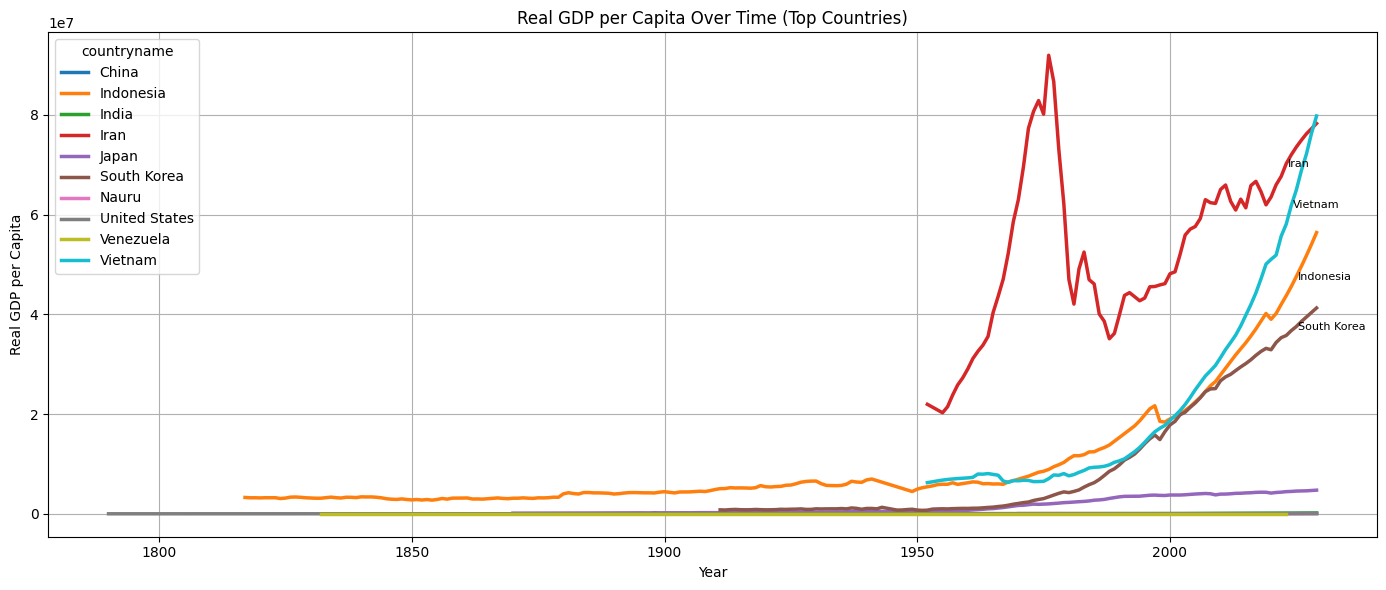

In [10]:
# Example: rGDP_pc over time for top 5 countries
subset = data[data['countryname'].isin(top_countries)]
threshold = 3e7

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=subset, x='year', y='rGDP_pc', hue='countryname', linewidth=2.5)

# Annotate final points only above threshold
last_points = df.sort_values('year').groupby('countryname').tail(1)
high_performers = last_points[last_points['rGDP_pc'] > threshold]

for _, row in high_performers.iterrows():
    plt.text(row['year'] + 0.3, row['rGDP_pc'], row['countryname'], fontsize=8, va='center')

# Style
plt.title('Real GDP per Capita Over Time (Top Countries)')
plt.xlabel('Year')
plt.ylabel('Real GDP per Capita')
plt.grid(True)
plt.tight_layout()
plt.show()


## Temporal Performance Trajectory Analysis

**Historical Development Patterns**: Examining GDP per capita evolution over time for top-performing countries to understand development trajectories and growth patterns. This temporal analysis reveals whether current high performance represents sustained growth or recent breakthrough, while identifying countries with consistent upward economic momentum versus those experiencing recent acceleration.

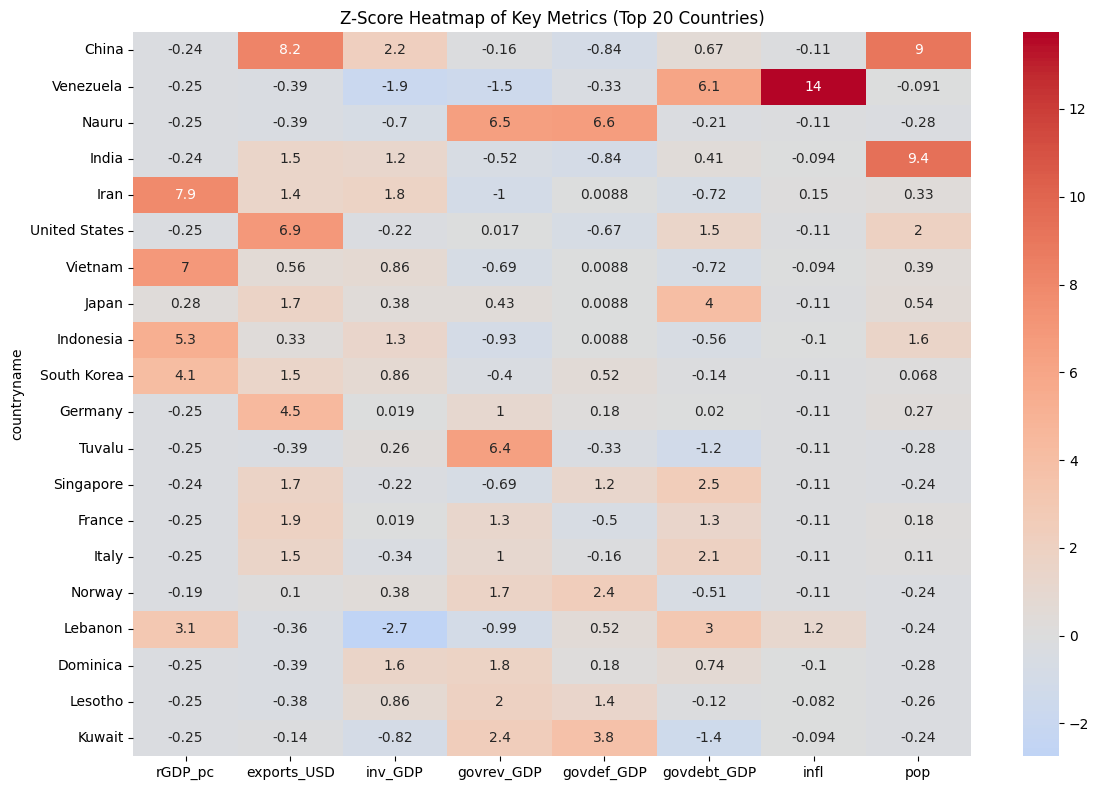

In [11]:
# Pivot to country vs metrics
heat_df = z_df.set_index('countryname')[metrics]

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(heat_df.head(20), annot=True, cmap='coolwarm', center=0)
plt.title('Z-Score Heatmap of Key Metrics (Top 20 Countries)')
plt.tight_layout()
plt.show()


## Multi-Dimensional Economic Performance Heatmap

**Comprehensive Metric Visualization**: Creating detailed heatmap analysis showing standardized performance across all economic dimensions for top-ranking countries. This visualization reveals performance patterns, highlighting countries that excel broadly versus those with concentrated strengths in specific areas, while identifying potential trade-offs between different economic objectives (growth vs. stability, fiscal health vs. investment).

## Economic Performance Insights & Global Implications

**Key Findings**: The z-score normalization approach reveals nuanced patterns in global economic performance beyond simple GDP rankings. Countries with high composite scores demonstrate balanced excellence across multiple economic dimensions, while the rising/falling metric separation identifies economies with strong fundamentals but fiscal challenges, or vice versa.

**Methodological Advantages**: Standardized scoring enables fair comparison between countries of vastly different scales and development levels. The dual-axis framework (rising vs. falling indicators) provides more sophisticated analysis than single composite scores, revealing trade-offs and specialization patterns in economic development strategies.

**Policy Implications**: High-performing countries in the rising metrics (GDP growth, exports, investment) combined with strong falling metrics (low debt, deficit, inflation) represent optimal economic management models. Countries excelling in one dimension but struggling in another highlight specific policy focus areas for economic improvement and sustainable development.